In [96]:
# ! pip install scikit-plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix,f1_score,accuracy_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from time import time
from skopt import dummy_minimize
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

# import Modellen
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


In [97]:
# Datei hochladen
median_klassifikation_team = pd.read_csv("median_klassifikation_team_v2.csv")
median_klassifikation_team.head()

,year,team_placement_2,height,weight,age,spieleranzahl,spieler_median,auslaender_prozent
0,2003,0,1.818743,76.018072,40.976190,168,33.600000,63.095238
1,2003,2,1.812329,76.712329,42.301370,73,24.333333,54.810496
2,2004,2,1.820952,76.904762,41.602410,84,28.000000,47.945205
3,2005,0,1.827250,76.925000,39.031250,160,32.000000,65.662651
4,2005,2,1.824366,77.070423,39.295775,71,23.666667,56.176471


- **Testdaten:**  Der verbleibende Teil des Datensatzes, ebenfalls 30 %, wird für die endgültige Bewertung des Modells verwendet. Diese Daten sollten während des gesamten Trainingsprozesses nicht gesehen werden. 


- Feature **'Year'** hat eine starke Korrelation mit 'team_placement_2' deswegen würden aus den Dataset rausgenommen. 


- Feature **spieleranzahl**

In [98]:
# Die Daten werden aufgeteilt in 30 % Testen und 70 % Training. 
# Die Testdaten werden nur zum Schluss verwendet und werden die Realität simulieren
train, test = train_test_split(median_klassifikation_team, test_size=0.30, random_state=42)


# Train und Valiedirung  
x = train.drop(columns=['team_placement_2','year','spieleranzahl'])
y = train.drop(columns=['year','age','height','weight','auslaender_prozent','spieler_median','spieleranzahl'])

# Final Model testen
X_test = test.drop(columns=['team_placement_2','year','spieleranzahl'])
y_test = test.drop(columns=['year','age','height','weight','auslaender_prozent','spieler_median','spieleranzahl'])


# reset index 
x= x.reset_index(drop=True)
y= y.reset_index(drop=True)

In [99]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 27 to 26
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                9 non-null      int64  
 1   team_placement_2    9 non-null      int64  
 2   height              9 non-null      float64
 3   weight              9 non-null      float64
 4   age                 9 non-null      float64
 5   spieleranzahl       9 non-null      int64  
 6   spieler_median      9 non-null      float64
 7   auslaender_prozent  9 non-null      float64
dtypes: float64(5), int64(3)
memory usage: 648.0 bytes


**Modelle vergleichen**

Um die verschiedenen Modelle zu bewerten, wurde eine Funktion mit Kreuzvalidierung erstellt. Diese verwendet KFold zur Aufteilung der Daten und berechnet die durchschnittliche Genauigkeit sowie die Standardabweichung der Genauigkeit für jedes Modell. Um die Stabilität und Robustheit der Modelle genauer zu überprüfen, wurde die RepeatedKFold-Methode angewendet.

**RepeatedKFold**:  ist ein leistungsstarkes Werkzeug, das die Zuverlässigkeit und Stabilität von Modellbewertungen verbessert, insbesondere bei **kleinen Datensätzen** oder wenn ein genauer Modellvergleich erforderlich ist. Diese Methode hilft dabei, die Varianz der Ergebnisse zu reduzieren und ermöglicht eine präzisere Einschätzung der Modellleistung.


Sie ist besonders nützlich in den folgenden Situationen:

**1. Kleine Datensätze**
Bei kleinen Datensätzen können zufällige Aufteilungen in Trainings- und Validierungssätze stark unterschiedliche Ergebnisse liefern. RepeatedKFold hilft dabei, diese Variabilität zu reduzieren, indem sie mehrere K-Fold-Kreuzvalidierungen durchführt und die Ergebnisse mittelt.

**2. Modellvergleich**
Wenn Sie verschiedene Modelle vergleichen möchten, bietet RepeatedKFold eine robustere Bewertung, da die Modelle über mehrere Wiederholungen hinweg getestet werden. Dies reduziert die Wahrscheinlichkeit, dass die Leistung eines Modells zufällig besser oder schlechter erscheint als in der Realität.

**3. Bewertung der Modellstabilität**
Wenn Sie wissen möchten, wie stabil die Leistung Ihres Modells ist, kann RepeatedKFold durch mehrere Wiederholungen zeigen, wie sehr die Ergebnisse variieren. Ein Modell, das in allen Wiederholungen ähnlich gute Ergebnisse liefert, ist stabiler als ein Modell, dessen Leistung stark schwankt.

**4. Schätzungen mit geringerer Varianz**
Durch die Wiederholung des K-Fold-Verfahrens wird die Varianz der Leistungsschätzungen reduziert, was zu genaueren und zuverlässigeren Schätzungen führt.


In [100]:
# Kreuzvalidierungsfunktion für Klassifikation
def cross_validate_model(models, x, y, n_splits=5):
    
    # Dict für die Ergbnisse
    results = {}
    scaler = MinMaxScaler()
    
    for name, model in models:
        accuracy_scores = []
        
         # KFold teilt die Daten in n_splits Folds auf.
         # Wiederholt die K-fache Aktion n-mal mit unterschiedlicher Zufallsverteilung bei jeder Wiederholung.
         # shuffle=True stellt sicher, dass die Daten vor der Aufteilung gemischt werden.
         # random_state=rep Die beispiele für jeden Block werden sich ändern 
         # Arlternative lösung  kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
        for rep in range(10):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=rep)
        
            # Durchführen der Kreuzvalidierung
            for train_index, val_index in kf.split(x):
                # Aufteilen der Daten in Trainings- und Validierungs-Sets, Hier werden in den Index zugreifen.:
                x_train, x_val = x.iloc[train_index], x.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]


                # LabelEncoder für "XGBClassifier"
                # XGBClassifier muss eine  Klassenspalte bei 0 beginnen (wie seit Version 1.3.2 erforderlich).
                # Eine einfache Lösung hierfür ist die Verwendung von LabelEncoder aus der Bibliothek sklearn.preprocssing.
                # Dies liegt daran, dass der y_train vor dem Training in einem 
                # neueren aktualisierten XGBoost-Modell codiert werden muss. 
                # Das heißt, Sie müssen eine kategorische Transformation wie Label-Encoder 
                le = LabelEncoder()
                y_train = le.fit_transform(y_train)
                
                # Anwenden des Scalers
                # Bei dem Training eines Machine Learning Modells ist es wichtig, dass der Skalierer lediglich an die Trainingsdaten angepasst wird und dann jedoch sowohl auf die Trainings- 
                # als auch auf die Testdaten angewandt wird. Dadurch ist die Konsistenz des Skalierungsprozesses sichergestellt.
                #if normalaize == False:
                x_train_s = scaler.fit_transform(x_train)
                x_val_s = scaler.transform(x_val)

                model.fit(x_train_s, y_train)
                y_pred = model.predict(x_val_s)

                # Berechnung der Genauigkeit
                accuracy = accuracy_score(y_val, y_pred)
                accuracy_scores.append(accuracy)
           
        # Accuracy und Standardabweichung in eine Liste speichern
        mean_accuracy = np.mean(accuracy_scores)
        std_accuracy = np.std(accuracy_scores)
        results[name] = (mean_accuracy, std_accuracy)
    
    return results

# Beispiel-Daten vorbereiten
# Zielvariable ist nun der direkte Teamplatz (1 bis 20)

#mean_league_team['target'] = mean_league_team['team_placement']

# Features und Zielvariable trennen
#x = mean_league_team[['age', 'height', 'weight']]
#y = mean_league_team['target']



# Liste von Modellen, die verglichen werden sollen
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')),
    ("Random Forest", RandomForestClassifier(random_state=0)),
    ("DecisionTreeClassifier",DecisionTreeClassifier(random_state=0)),
    ("SGDClassifier",SGDClassifier(random_state=0)),
    ("LGBMClassifier",LGBMClassifier(random_state=0)),
    ("XGBClassifier",XGBClassifier(random_state=0)),
    ("SVC",SVC(random_state=0)),
    ("AdaBoostClassifier",AdaBoostClassifier(random_state=0)),
    ("xgboost",XGBClassifier(random_state=0))
]

# Kreuzvalidierung durchführen und Ergebnisse speichern
stard = time()
results = cross_validate_model(models, x, y)
end = time()
time = abs(stard - end)
print('Time:',round(time,1))
print(" ")

# Ergebnisse anzeigen
for name, (mean_accuracy, std_accuracy) in results.items():
    print(f"Model: {name}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation: {std_accuracy:.4f}\n")

Time: 12.7
 
Model: Logistic Regression
Mean Accuracy: 0.5950
Standard Deviation: 0.2285

Model: Random Forest
Mean Accuracy: 0.6200
Standard Deviation: 0.2015

Model: DecisionTreeClassifier
Mean Accuracy: 0.5350
Standard Deviation: 0.2292

Model: SGDClassifier
Mean Accuracy: 0.5450
Standard Deviation: 0.2631

Model: LGBMClassifier
Mean Accuracy: 0.6000
Standard Deviation: 0.2345

Model: XGBClassifier
Mean Accuracy: 0.6400
Standard Deviation: 0.1881

Model: SVC
Mean Accuracy: 0.5900
Standard Deviation: 0.2437

Model: AdaBoostClassifier
Mean Accuracy: 0.6500
Standard Deviation: 0.2121

Model: xgboost
Mean Accuracy: 0.6400
Standard Deviation: 0.1881



In [127]:
# Train und Valiedirung  year wird raus genommen wegen die Multikollinearität mit und age 
#x = median_klassifikation_team.drop(columns=['team_placement_2','year','spieleranzahl'])
#y = median_klassifikation_team.drop(columns=['year','age','height','weight','auslaender_prozent','spieler_median','spieleranzahl'])

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42, shuffle=True)

# Anwenden des Scalers
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Hyperparameter-Tuning**

- **Bayesian Optimization:**

Bayesian Optimization ist eine effiziente Methode zur Optimierung von Funktionen, die teuer zu bewerten sind. Es wird häufig im Kontext von Hyperparameter-Tuning in maschinellen Lernverfahren verwendet, wo es darauf ankommt, die besten Parameter zu finden, um die Leistung eines Modells zu maximieren oder zu minimieren.

- **Wie funktioniert Bayesian Optimization?**

Im Gegensatz zu klassischen Optimierungsmethoden, die systematisch oder zufällig den Parameterraum durchsuchen (z.B. Grid Search oder Random Search), nutzt Bayesian Optimization probabilistische Modelle, um die Funktion zu approximieren, die optimiert werden soll. Diese Methode integriert Wissen aus bisherigen Evaluierungen, um den nächsten Punkt zu wählen, der am vielversprechendsten ist. Dadurch wird die Anzahl der Evaluierungen minimiert und die Effizienz der Optimierung erhöht.


**Vorteile der Bayesian Optimization**

- **Effizienz:** Da Bayesian Optimization sich auf bereits vorhandenes Wissen stützt und nur vielversprechende Punkte evaluiert, ist es besonders effizient für Probleme, bei denen die Evaluierung der Funktion teuer ist.


- **Flexibilität:** Es kann auf jede Funktion angewendet werden, die teuer zu berechnen ist und keine geschlossene Form hat.


- **Parallelisierbarkeit:** Verschiedene Akquisitionsfunktionen können angepasst werden, um parallele Evaluierungen zu ermöglichen, was den Prozess weiter beschleunigt.

In [128]:
# AdaBoost-Modell mit einem DecisionTreeClassifier als Basis-Estimator
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42))

# Definition des Hyperparameter-Suchraums
param_space = {
    'n_estimators': Integer(50, 200),
    'learning_rate': Real(0.01, 0.08, prior='log-uniform'),
    'base_estimator__max_depth': Integer(1, 10),
    "algorithm": ["SAMME.R"]  # Algorithmus-Typ
}


In [129]:
# Bayesian Optimization mit 5-facher Kreuzvalidierung
bayes_cv_tuner = BayesSearchCV(
     estimator=adaboost,
    search_spaces=param_space,
     n_iter=20,  # Anzahl der Iterationen
    cv= RepeatedKFold(
          n_splits=7,
          random_state=42),  # Kreuzvalidierung mit 5 Folds auf den Trainingsdaten
     n_jobs=-1,  # Verwende alle verfügbaren CPUs
    random_state=42
)

# # Modell mit optimierten Parametern auf den Trainingsdaten trainieren
best_model = bayes_cv_tuner.fit(X_train, y_train)

# # Die besten Hyperparameter anzeigen
print("Beste Hyperparameter: ", best_model.best_params_)
print("Beste Trainings-Score: ", best_model.best_score_)


# # Testgenauigkeit auf den Testdaten
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Beste Hyperparameter:  OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator__max_depth', 9), ('learning_rate', 0.047758216279353075), ('n_estimators', 174)])
Beste Trainings-Score:  0.6583333333333332
Test Accuracy: 0.8333


**Beste Hyperparameter:**

- **algorithm: 'SAMME.R':**
Dieser Parameter gibt an, welcher Boosting-Algorithmus verwendet wird. 'SAMME.R' ist eine verbesserte Version des ursprünglichen 'SAMME'-Algorithmus, die die Wahrscheinlichkeiten der Vorhersagen direkt verwendet und dadurch tendenziell effizienter ist.

- **base_estimator__max_depth: 1:** Das ist die maximale Tiefe des Entscheidungsbaums (des Basis-Estimators). Eine Tiefe von 1 bedeutet, dass jeder Entscheidungsbaum in deinem AdaBoost-Modell ein sogenannter "Stumpf" ist, d.h., ein Baum mit nur einer Entscheidung pro Feature. Diese einfache Struktur reduziert das Risiko von Overfitting.

- **learning_rate: 0.04**
Die Lernrate bestimmt, wie stark neue Bäume die Fehler der vorherigen Bäume korrigieren. Eine Lernrate von 1.0 bedeutet, dass jeder Baum den Fehler der vorherigen vollständig korrigiert, was zu schnelleren Anpassungen führt.

- **n_estimators: 174**
Das ist die Anzahl der Bäume, die in der Boosting-Sequenz trainiert werden. Mehr Bäume können die Genauigkeit erhöhen, aber auch die Rechenzeit verlängern.

- **Beste Trainings-Score: 0.61**
Dieser Wert gibt an, dass das Modell mit den besten gefundenen Hyperparametern während der Cross-Validation auf den Trainingsdaten eine Genauigkeit von etwa 78,57 % erreicht hat.

- **Test Accuracy: 0.83**
Das ist die Genauigkeit des optimierten Modells auf den Testdaten, die nicht im Training verwendet wurden. Eine Testgenauigkeit von 83,33 % zeigt, dass das Modell gut generalisiert und auch auf ungesehenen Daten gute Vorhersagen macht.


**Gesamtinterpretation:**
- Das Modell hat eine ordentliche Leistung erbracht, wobei die Testgenauigkeit (0,8333) deutlich höher ist als der Trainings-Score (0,6583). Dies könnte darauf hinweisen, dass das Modell gut generalisiert und nicht überangepasst ist. 


- Die relativ niedrige Lernrate (0,0477) und die größere Tiefe des Basis-Schätzers (max_depth = 9) deuten darauf hin, dass das Modell detaillierte Muster in den Daten erfasst, jedoch langsam lernt, was die Generalisierungsfähigkeit unterstützt.


- Insgesamt zeigt das Modell eine gute Balance zwischen der Modellkomplexität und der Generalisierungsfähigkeit, wie durch die relativ hohe Testgenauigkeit gezeigt wird. Es könnte jedoch von weiteren Anpassungen oder zusätzlichen Daten profitieren, um die Trainingsgenauigkeit zu erhöhen und eventuell die Testgenauigkeit weiter zu verbessern.



In [130]:
# # modelo final
# xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
# xgb.fit(X_train_rus, y_train_rus)

# # fazer a previsão
# X_test = scaler.transform(X_test)
# y_pred = xgb.predict(X_test)

# # Classification Report
# print(classification_report(y_test, y_pred))

# # imprimir a área sob a curva
# print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# # plotar matriz de confusão
# plot_confusion_matrix(y_test, y_pred, normalize=True)
# plt.show()

In [161]:
ado = AdaBoostClassifier(algorithm='SAMME', learning_rate= 0.04, n_estimators=200, random_state=0)

# Training 
ado.fit(X_train,y_train)

# Final Test, die Daten wurden noch nicht von den Model gesehen.
X_test = test.drop(columns=['team_placement_2','year','spieleranzahl'])
y_test = test.drop(columns=['year','age','height','weight','auslaender_prozent','spieler_median','spieleranzahl'])


# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = ado.predict(X_test)

# # Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.00      0.00      0.00         1
           2       0.75      1.00      0.86         3

    accuracy                           0.89         9
   macro avg       0.58      0.67      0.62         9
weighted avg       0.81      0.89      0.84         9



In [162]:
##MATRIZ DE CONFUSÃO DO SKLEARN
confusion_matrix(y_pred=y_pred,y_true= y_test)

array([[5, 0, 0],
       [0, 0, 1],
       [0, 0, 3]], dtype=int64)

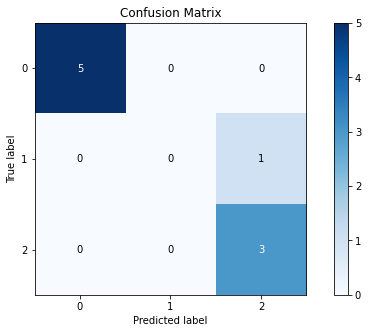

In [163]:
plot_confusion_matrix(y_test[0:9], y_pred)
plt.show()

In [164]:
## ACURACIA
print("ACURÁCIA: ", accuracy_score(y_pred=y_pred,y_true=y_test)*100)

## F-SCORE
print("F1-SCORE: ", f1_score(y_pred=y_pred,y_true=y_test,average='macro')*100)

ACURÁCIA:  88.88888888888889
F1-SCORE:  61.904761904761905


**Metriken für jede Klasse:**

**Klasse 0:**

- **Precision:** 1.00: Von allen Vorhersagen, die das Modell als Klasse 0 klassifiziert hat, waren 100 % tatsächlich Klasse 0.
- **Recall:** 1.00: Von allen tatsächlichen Instanzen der Klasse 0 hat das Modell 100 % korrekt vorhergesagt.
- **F1-Score:** 1.00: Dies ist der harmonische Mittelwert von Precision und Recall, der ebenfalls perfekt ist.
- **Support:** 5: Es gab 5 Instanzen der Klasse 0 in den Testdaten.

**Klasse 1:**

- **Precision:** 0.00: Keine der Vorhersagen für Klasse 1 war korrekt, was darauf hinweist, dass das Modell Schwierigkeiten hatte, diese Klasse zu identifizieren.
- **Recall:** 0.00: Das Modell konnte keine der tatsächlichen Instanzen der Klasse 1 korrekt identifizieren.
- **F1-Score:** 0.00: Dies zeigt, dass das Modell bei der Klasse 1 völlig versagt hat.
- **Support:** 1: Es gab nur eine Instanz der Klasse 1 in den Testdaten, und das Modell hat sie nicht korrekt erkannt.

**Klasse 2:**

- **Precision:** 0.75: Von den Vorhersagen, die das Modell als Klasse 2 klassifiziert hat, waren 75 % korrekt.
- **Recall:** 1.00: Von allen tatsächlichen Instanzen der Klasse 2 hat das Modell 100 % korrekt vorhergesagt.
- **F1-Score:** 0.86: Dies zeigt eine gute, aber nicht perfekte Leistung bei der Vorhersage von Klasse 2.
- **Support:** 3: Es gab 3 Instanzen der Klasse 2 in den Testdaten.


**Accuracy: 0.89:** Das Modell hat insgesamt 89 % der Testinstanzen korrekt klassifiziert, was ein Hinweis darauf ist, dass das Modell im Allgemeinen gut performt.

**Macro avg (Durchschnitt über alle Klassen):**

- **Precision:** 0.58: Der ungewichtete Durchschnitt der Präzision über alle Klassen.
- **Recall:** 0.67: Der ungewichtete Durchschnitt des Recalls über alle Klassen.
- **F1-Score:** 0.62: Der ungewichtete Durchschnitt des F1-Scores über alle Klassen.
- **Support:** 9: Die Gesamtzahl der Instanzen in den Testdaten.


**Weighted avg (gewichteter Durchschnitt):**

- **Precision:** 0.81: Der gewichtete Durchschnitt der Präzision unter Berücksichtigung des Supports jeder Klasse.
- **Recall:** 0.89: Der gewichtete Durchschnitt des Recalls.
- **F1-Score:** 0.84: Der gewichtete Durchschnitt des F1-Scores.

**Gesamtinterpretation:**

Das Modell zeigt insgesamt eine gute Leistung, besonders bei den Klassen 0 und 2. Allerdings hat es Schwierigkeiten mit Klasse 1, die möglicherweise aufgrund der geringen Anzahl an Instanzen in den Daten und/oder der Schwierigkeit, diese Klasse von den anderen zu unterscheiden, entstanden sind. Dies führt zu einem niedrigen Macro Average, aber der Weighted Average bleibt hoch, da die meisten Instanzen richtig klassifiziert wurden. Es könnte sinnvoll sein, Methoden wie das Oversampling oder das Anpassen der Klassenverteilung zu verwenden, um die Leistung für Klasse 1 zu verbessern.

Die weighted average Werte sind höher als die macro average Werte, was darauf hinweist, dass das Modell bei den häufigeren Klassen (0 und 2) besser abgeschnitten hat.
Um das Modell zu verbessern, könnte man versuchen, mehr Daten für Klasse 1 zu sammeln oder Methoden wie das Anpassen der Klassenverhältnisse oder die Anwendung von Gewichtungen in den Verlustfunktionen in Betracht ziehen.


**FEATURE IMPORTANCE**

In [165]:
for i in zip(x.columns, ado.feature_importances_):
  print(i)

('height', 0.07153785591168502)
('weight', 0.0953934910687356)
('age', 0.12690709539936024)
('spieler_median', 0.05223658213714126)
('auslaender_prozent', 0.6539249754830776)


('height', 0.0)
('weight', 0.06589573508917418)
('age', 0.079342765233142)
('spieler_median', 0.0)
('auslaender_prozent', 0.8547614996776842)

<AxesSubplot:>

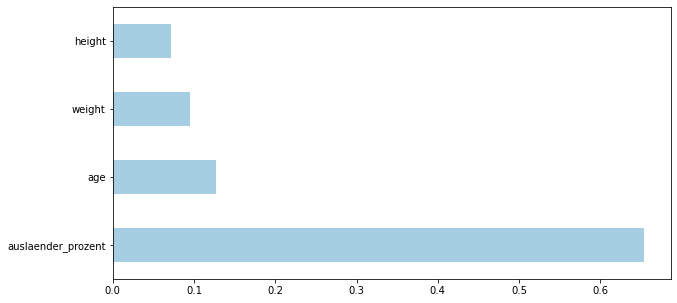

In [166]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
feat_importances = pd.Series(ado.feature_importances_, index=x.columns)
feat_importances.nlargest(4).plot(kind='barh',colormap='Paired')

1. Höhe (height):

     - Die Höhe der Spieler hat eine Feature-Importance von etwa 0,0715. Dies bedeutet, dass die Höhe einen gewissen, aber nicht dominanten Einfluss auf die Klassifikation im Modell hat. Es könnte sein, dass die Körpergröße in gewissen Kontexten eine Rolle spielt, zum Beispiel bei spezifischen Positionen oder Spielstilen, aber sie ist nicht das entscheidende Merkmal.


2. Gewicht (weight):

   -  Das Gewicht der Spieler zeigt eine etwas höhere Bedeutung mit einem Wert von 0,0954. Dies könnte darauf hinweisen, dass das Gewicht ein etwas relevanterer Faktor für die Klassifikation ist, vielleicht im Zusammenhang mit der körperlichen Präsenz auf dem Spielfeld oder der Position der Spieler.
   

3. Alter (age):

    - Das Alter hat eine Feature-Importance von 0,1269, was es zu einem wichtigen Merkmal macht. Dies deutet darauf hin, dass das Alter der Spieler eine signifikante Rolle spielt, möglicherweise weil es mit Erfahrung, Fitness oder Leistungsfähigkeit korreliert ist.
    

4. Median der Spieleranzahl (spieler_median):

    - Mit einer Feature-Importance von 0,0522 hat dieses Merkmal den geringsten Einfluss auf das Modell. Dies könnte bedeuten, dass die Anzahl der Spieler im Kader in Bezug auf die Zielvariable weniger relevant ist, zumindest im Kontext dieses spezifischen Datensatzes und Modells.
    

5. Prozentsatz der ausländischen Spieler (auslaender_prozent):

    - Der Prozentsatz der ausländischen Spieler sticht mit einer Feature-Importance von 0,6539 deutlich hervor. Dieses Merkmal ist mit Abstand das wichtigste für das Modell und könnte stark mit dem Erfolg oder der Platzierung der Mannschaften korreliert sein. Ein hoher Anteil ausländischer Spieler könnte auf eine bessere internationale Qualität hinweisen oder andere Vorteile mit sich bringen, die sich positiv auf die Leistung der Mannschaft auswirken.

**Zusammenfassung**

Das AdaBoost-Modell zeigt, dass der Prozentsatz der ausländischen Spieler der wichtigste Faktor ist, der die Zielvariable beeinflusst, gefolgt vom Alter der Spieler und Gewicht. Höhe und Median der Spieleranzahl spielen eine untergeordnete Rolle. Diese Analyse kann Hinweise darauf geben, welche Faktoren in zukünftigen Modellen oder Entscheidungen stärker berücksichtigt werden sollten.